# Learning CartPole with a Monte-Carlo Reinforce Algorithm!
This notebook will tackle the game of CartPole using a policy gradient method known as Monte-Carlo Reinforce! The CartPole environment is readily available through OpenAI's gym module.


## Policy Gradient
The first approach will be the policy-gradient method. The main idea of this method is to use a function approximator to directly learn an optimal policy i.e. the mapping from a state to an action. 

In this case, I will be using a shallow neural network as the function approximator for the policy and the weights will be optimised in such a way to maximise an objective function related to the performance of the agent in the CartPole environment. Specifically, the objective function will be the sum of the discounted rewards over every state in the episode. 

$$J(\theta) = \mathbb{E}_\pi \bigg[\sum_{t=1}^{T-1} R(s_t, a_t)\bigg] = \mathbb{E}_\pi \bigg[ \sum_{t=1}^{T-1} r_t + \gamma R(s_{t+1}, a_{t+1}) \bigg] = \sum_{a\in A}\sum_{t=1}^{T-1}\pi_\theta(a_t | s_t) (r_t + \gamma R(s_{t+1}, a_{t+1})) $$

where $r_t$ is the immediate reward of a state at time t, $\gamma$ is the discount factor, $\pi_\theta$ is the policy parametrised by $\theta$, and R(s_t, a_t) is the discount rewards at time step t.

The neural network parameters will be updated via a gradient ascent method, and therefore we will need to calculate the gradient of the objective with respect to the parameters, $\theta$, of the network, $\nabla_\theta J(\theta)$. 

$$\nabla_\theta J(\theta) = \nabla_\theta (\sum_{a\in A}\sum_{t=1}^{T-1} \pi_\theta(a_t|s_t) (r_t + \gamma R(s_{t+1}, a_{t+1}))) = \sum_{a\in A}\sum_{t=1}^{T-1} \nabla_\theta\pi_\theta(a_t | s_t) (r_t + \gamma R(s_{t+1}, a_{t+1}))$$

Differentiating a probability distribution can be hard, unless we log it. Therefore, we will use the log-trick to transform the problem. 

Log trick:

$$\nabla_\theta\pi_\theta = \pi_\theta \nabla_\theta \log(\pi_\theta) $$

Substituting this into $\nabla_\theta J(\theta)$ we get:

$$\nabla_\theta J(\theta) = \sum_{a\in A}\sum_{t=1}^{T-1} \pi_\theta (a_t | s_t) \nabla_\theta \log(\pi_\theta(a_t | s_t)) (r_t + \gamma R(s_{t+1}, a_{t+1}))$$

$$\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \bigg[\sum_{t=1}^{T-1} \nabla_\theta\log(\pi_\theta(a_t | s_t))  (r_t + \gamma R(s_{t+1}, a_{t+1}))\bigg]$$

Therefore, after every episode we will make a gradient descent update of the weights using the following gradient: 

$$\nabla_\theta J(\theta) = \sum_{t=1}^{T-1} \nabla_\theta\log(\pi_\theta(a_t | s_t))  (r_t + \gamma R(s_{t+1}, a_{t+1}))$$




### Import necessary modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from policy_gradient import PolicyNetwork, PGAgent

### Instantiate the environment of CartPole & Agent Parameters

In [2]:
env = gym.make("CartPole-v0")

state_space = env.observation_space
action_space = env.action_space    
episodes = 1000

hidden_size = 16
discount = 0.99

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Run experiments training the agent

In [3]:
number_of_runs = 10
run_rewards = []

for run in range(number_of_runs):
    policy_network = PolicyNetwork(state_space, action_space, hidden_size).double()
    agent = PGAgent(policy_network, discount)

    optimiser = optim.RMSprop(policy_network.parameters())

    episode_rewards = []
    for episode in range(episodes):

        state = torch.from_numpy(env.reset())
        agent.reset_policy()

        total_reward = 0
        done = False
        while not done:
            action = agent.select_action(state)
            state, reward, done, _ = env.step(action.data.numpy())
            total_reward += reward

            state = torch.tensor(state)
            reward = torch.tensor(reward)
            
            agent.policy_reward.append(reward)

        loss, _ = agent.update_policy(optimiser)

        episode_rewards.append(total_reward)

        if episode % 20 == 0 and run == 0:
            print("Episode: %d -> Loss: %.4f, Reward: %.4f" % (episode, loss, total_reward))

    run_rewards.append(episode_rewards)

/usr/local/lib/python3.7/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Episode: 0 -> Loss: -0.4577, Reward: 11.0000
Episode: 20 -> Loss: -1.3354, Reward: 46.0000
Episode: 40 -> Loss: 3.8633, Reward: 100.0000
Episode: 60 -> Loss: 3.3356, Reward: 97.0000
Episode: 80 -> Loss: -8.7920, Reward: 200.0000
Episode: 100 -> Loss: -1.2606, Reward: 114.0000
Episode: 120 -> Loss: -1.4368, Reward: 200.0000
Episode: 140 -> Loss: 2.4573, Reward: 200.0000
Episode: 160 -> Loss: -1.9730, Reward: 160.0000
Episode: 180 -> Loss: 0.5132, Reward: 200.0000
Episode: 200 -> Loss: 6.2058, Reward: 200.0000
Episode: 220 -> Loss: 2.2149, Reward: 161.0000
Episode: 240 -> Loss: -2.6421, Reward: 200.0000
Episode: 260 -> Loss: -0.3999, Reward: 200.0000
Episode: 280 -> Loss: -3.2958, Reward: 200.0000
Episode: 300 -> Loss: 1.8253, Reward: 200.0000
Episode: 320 -> Loss: -4.4582, Reward: 200.0000
Episode: 340 -> Loss: -4.3634, Reward: 200.0000
Episode: 360 -> Loss: 2.5305, Reward: 200.0000
Episode: 380 -> Loss: 3.4603, Reward: 200.0000
Episode: 400 -> Loss: 1.1417, Reward: 129.0000
Episode: 42

### Plot the moving average of the final score of each episode

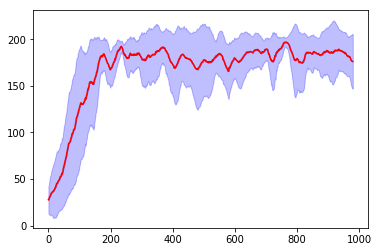

In [4]:
%matplotlib inline
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

import matplotlib.pyplot as plt

means = np.mean([moving_average(rewards) for rewards in run_rewards], axis=0)
stds = np.std([moving_average(rewards) for rewards in run_rewards], axis=0)

plt.plot(range(len(means)), means, color='red')

plt.fill_between(range(len(means)), means, means + stds, color='blue', alpha=.25)
plt.fill_between(range(len(means)), means, means - stds, color='blue', alpha=.25)

plt.show()